In [47]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
# from scipy.misc import imread
import cv2
import time
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, Concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle


In [ ]:
%matplotlib inline

In [29]:
# Path to folder
train_folder = "images_background"
val_folder = "images_evaluation"
save_path = "data"

## Loading Image ##

In [78]:
def loadimgs(path, n = 0):
    X=[]
    y=[]
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        if alphabet == '.DS_Store':
            continue
        print("Loadin alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y, None]
        alphabet_path = os.path.join(path, alphabet)
        # every letter/category has it's own column in the array, so load seper
        for letter in os.listdir(alphabet_path):
            if letter == '.DS_Store':
                # For macosx
                continue
            cat_dict[curr_y] = (alphabet, letter)
            category_images = []
            letter_path = os.path.join(alphabet_path, letter)
            
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                if filename == '.DS_Store':
                    continue
                image_path = os.path.join(letter_path, filename)
                image = plt.imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
                # edge case - last one
            except ValueError as e:
                print(e)
                print("Error - category_images:", category_images)
                    
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X, y, lang_dict
                

In [85]:
X, y, c = loadimgs(train_folder)
print("done")

Loadin alphabet: Gujarati
Loadin alphabet: Korean
Loadin alphabet: Arcadian
Loadin alphabet: Malay_(Jawi_-_Arabic)
Loadin alphabet: Grantha
Loadin alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
Loadin alphabet: Balinese
Loadin alphabet: Futurama
Loadin alphabet: N_Ko
Loadin alphabet: Burmese_(Myanmar)
Loadin alphabet: Anglo-Saxon_Futhorc
Loadin alphabet: Mkhedruli_(Georgian)
Loadin alphabet: Latin
Loadin alphabet: Braille
Loadin alphabet: Sanskrit
Loadin alphabet: Japanese_(hiragana)
Loadin alphabet: Tagalog
Loadin alphabet: Greek
Loadin alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
Loadin alphabet: Japanese_(katakana)
Loadin alphabet: Early_Aramaic
Loadin alphabet: Hebrew
Loadin alphabet: Tifinagh
Loadin alphabet: Asomtavruli_(Georgian)
Loadin alphabet: Armenian
Loadin alphabet: Syriac_(Estrangelo)
Loadin alphabet: Alphabet_of_the_Magi
Loadin alphabet: Cyrillic
Loadin alphabet: Bengali
Loadin alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
done


## Saving the train sensor

In [ ]:
# np.savez("train", X=X,c=c)
np.save("train", (X,c), allow_pickle=True)

In [87]:
Xval, yval, cval = loadimgs(val_folder)
print("Done")

Loadin alphabet: Oriya
Loadin alphabet: ULOG
Loadin alphabet: Tengwar
Loadin alphabet: Malayalam
Loadin alphabet: Atlantean
Loadin alphabet: Keble
Loadin alphabet: Manipuri
Loadin alphabet: Gurmukhi
Loadin alphabet: Tibetan
Loadin alphabet: Aurek-Besh
Loadin alphabet: Ge_ez
Loadin alphabet: Angelic
Loadin alphabet: Old_Church_Slavonic_(Cyrillic)
Loadin alphabet: Kannada
Loadin alphabet: Avesta
Loadin alphabet: Mongolian
Loadin alphabet: Syriac_(Serto)
Loadin alphabet: Atemayar_Qelisayer
Loadin alphabet: Sylheti
Loadin alphabet: Glagolitic
Done


In [121]:
# Saving Validation tensors
np.save("eval", (Xval, cval), allow_pickle=True)
# np.savez("eval", Xval=Xval, cval=cval)

In [42]:
#del Xval, yval, cval, X, y, c

In [59]:
def initialize_weights(shape, **kwargs):
    """
     It was recommended to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc=0.0, scale=1e-2, size=shape)

In [60]:
def initialize_bias(shape, **kwargs):
    return np.random.normal(loc=0.5, scale=1e-2, size=shape)

In [64]:
def get_siamese_model(input_shape):
    
    # define the tensor for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # The CNN
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                     kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation="relu",  input_shape=input_shape,
                     bias_initializer=initialize_bias,
                     kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation="relu",  input_shape=input_shape,
                     bias_initializer=initialize_bias,
                     kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation="relu",  input_shape=input_shape,
                     bias_initializer=initialize_bias,
                     kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation="sigmoid", 
                    kernel_regularizer=l2(1e-3),
                    kernel_initializer=initialize_weights,
                    bias_initializer=initialize_bias
                   ))
    
    # Generate the encoding 
    encoded_1 = model(left_input)
    encoded_r = model(right_input)
    
    #Add a customized layer layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_1, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1, activation="sigmoid", bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the input with the outputs
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

    return siamese_net 

In [65]:
model = get_siamese_model((105,105, 1))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 4096)         38947648    input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 4096)         0           sequential_5[1][0]         

In [83]:
optimizer = Adam(lr=0.00006)
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [185]:
# Loading train tensors
Xtrain, train_classes = np.load("train.npy", allow_pickle=True)
# training_data = np.load("train.npz", allow_pickle=True)

In [122]:
Xval, val_classes = np.load("eval.npy", allow_pickle=True)

In [193]:
def get_batch(batch_size, s="train"):
    """
        create batch of n pairs, half same class, half different class
    """
    if s == "train":
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w , h = X.shape

    # randomly sample several classes to use in the batch
    categories = np.random.choice(n_classes, size=(batch_size,), replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs = [np.zeros((batch_size, h, w, 1)) for i in range(2)]
    
    #initialize vector for the targets
    targets = np.zeros((batch_size, ))
    
    #make one half of it 1's and so 2nd hald of batch has same class
    
    targets [batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = np.random.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = np.random.randint(0, n_examples)
        
        # pick images of same class for 1s half, different for 2nd
        if 1 >= batch_size // 2:
            category_2 = category
        else:
            # add a random number to the category modulo n classess to ensure 2nd  image has a different category
            category_2 = (category * rng.randint(1, n_classes)) % n_classes
        pairs[1][i,:,:,:] = X[category_2, idx_2].reshape(w, h, 1)
        
    return pairs, targets

In [156]:
def genereate(batch_size, s='train'):
    """
        a generator for batches, so model.fit_generator can be used
    """
    while True:
        pairs, target = get_batch(batch_size, s)
        yield(pairs, target)

In [190]:
 def make_oneshot_task(N, s="val", language=None):
        """
            Create pairs of test image support set for testing N way one-shot learning
        """
        if s == "train":
            X = Xtrain
            categories = train_classes
        else:
            X = Xval
            categories = val_classes
        n_classes, n_examples, w, h = X.shape
        
        indices = np.random.randint(0, n_examples, size=(N,))
        if language is not None:
            low, high = categories[language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = np.random.choice(range(low, high), size=(N,), replace=False)
        else:
            categories = np.random.choice(range(n_classes), size=(N,), replace=False)
        true_category = categories[0]
        ex1, ex2 = np.random.choice(n_examples, replace=False, size=(2,))
        test_image = np.asarray([X[true_category, ex1,:,:]] * N).reshape(N, w, h, 1)
        support_set = X[categories, indices, :, :]
        support_set[0,:,:] = X[true_category, ex2]
        support_set = support_set.reshape(N, w, h, 1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image, support_set]
        return pairs, target

In [164]:
def test_oneshot(model, N, k, s="val", verbose=0):
    """
        Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks
    """
    n_correct = 0
    if verbose:
        print("Evaluating model on {} randowm way one-shot learning task...\n".format(k,N))
    for i in range(k):
        inputs, target = make_oneshot_task(N, s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
        percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [195]:
# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 32
# n_iter = 20000 # No of training iterations
n_iter = 20 # No of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

In [167]:
model_path = 'weights/'

In [194]:
print("Starting training process!")
print("----------------------------------")
t_start = time.time()
for i in range(1, n_iter +1):
    (inputs, targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------------ \n")
        print("Time for {0} iterations: {1}mins".format(i, (tiem.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss))
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
----------------------------------


KeyboardInterrupt: 

In [ ]:
# Load model weights
model.load_weights(os.path.join(model_path, "weights.20000.h5"))

In [168]:
#Testing 
#Baselin model based on Nearest Neighbors using Euclidean Distance (L2 Distance)
def nearest_neighbor_correct(pairs, targets):
    """
        returns 1 if nearest neighbour gets the correct answer for a one-shot task given by (pairs, target)
    """
    L2_distances = np.zeros_list(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [169]:
def test_nn_accuracy(N_ways, n_trials):
    """Returns accuracy of NN approach"""
    print("Evaluating nearest neighbor on {} unique {} way one-shot learning task".format(n_trial, N_ways))
    n_right = 0
    
    for i in range(n_trials):
        pairs, targets = make_oneshot_task(N_ways, 'val')
        correct = nearest_neighbor_correct(pairs, targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [171]:
ways = np.arange(1, 20, 2)
resume = False
trial = 50

In [ ]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("---------------------------------------------------------------------------------------------------------------")

In [172]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [173]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

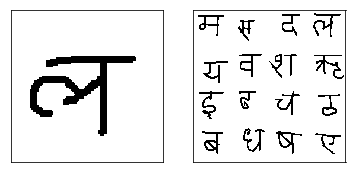

In [191]:
pairs, targets = make_oneshot_task(16,"train","Sanskrit")
plot_oneshot_task(pairs)